# IHA2 - Catching Pokemon

![](http://tibetanitech.com/wp-content/uploads/2016/09/Pokemon-GO.jpg)

In this home assignment, you'll apply roughly the same principles we used when doing logistic regression on the Iris dataset, but on a new and very interesting dataset. We'll use the [Predict'em All](https://www.kaggle.com/semioniy/predictemall) dataset from Kaggle (download the dataset directly from them). This dataset consists of roughly 293,000 [pokemon](http://www.pokemongo.com/) sightings (historical appearances of Pokemon in the Pokemon Go game), having coordinates, time, weather, population density, distance to pokestops/ gyms etc. as features. A comprehensive list of all the features is available at [the dataset's homepage](https://www.kaggle.com/semioniy/predictemall)

The context is simple: you are a Pokemon hunter, and there are only three Pokemon left for you to complete your collection. You'll do anything to capture them, including changing where you'll spend your next holidays! You know that some Pokemon only spawn in certain places of the world. Since you like machine learning so much, you figure it would be a great idea to train a classifier that, based on a location's latitude and longitude, can tell us which Pokemon is more likely to appear there.

The assignment is broken down into six steps.

1. Loading the data and extracting the desired subset of it
2. Visualization of the dataset
3. Preprocessing
4. Training
5. Evaluation
6. Exploration


Feel free to add cells wherever you see fit, and play around with this notebook as much as you want when developing the solutions. However, the solution you upload to ping-pong must have the exact format shown here, with only the cells present here.

Don't restrict yourself only to what was taught so far. Some of the tasks might require you to search for new information. [The python docs](https://docs.python.org/3/), [keras docs](https://keras.io/), [stackoverflow](https://stackoverflow.com/), and Google are your friends!

## 0. Imports

Import any necessary modules here.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

C:\Users\sandr\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Loading and extracting subset

Load the `'300k.csv'` file using pandas.

In [8]:
df = pd.read_csv('300k.csv', low_memory=False)
df.head()

,pokemonId,latitude,longitude,appearedLocalTime,_id,cellId_90m,cellId_180m,cellId_370m,cellId_730m,cellId_1460m,...,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151,class
0,16,20.525745,-97.460829,2016-09-08T03:57:45,NTgxMDkzOTk4MTM5MjUwMjIzNw==,9645139108510564000,9645139108711890000,9645139108443455000,9645139109517197000,9645139113812165000,...,False,False,False,False,False,False,False,False,False,16
1,133,20.523695,-97.461167,2016-09-08T03:57:37,OTQ1NDgzODc1MjM3NDEzMTI2MQ==,9645139109852742000,9645139109785633000,9645139110590940000,9645139109517197000,9645139113812165000,...,False,False,False,False,False,False,False,False,False,133
2,16,38.903590,-77.199780,2016-09-08T03:57:25,NTQ0OTQ0NDA1Nzg2ODg3OTg2OQ==,9923201472785285000,9923201472986612000,9923201473791918000,9923201477013144000,9923201481308110000,...,False,False,False,False,False,False,False,False,False,16
3,13,47.665903,-122.312561,2016-09-08T03:56:22,NTU2MTU1NDM4NzA2MDk1MDcxNw==,6093392705025474600,6093392705092583400,6093392705897889800,6093392702676664300,6093392715561566200,...,False,False,False,False,False,False,False,False,False,13
4,133,47.666454,-122.311628,2016-09-08T03:56:08,MTY2ODg4MTAzMTczMDE0MTUwNTM=,6093392707709829100,6093392707776938000,6093392708045373400,6093392711266598900,6093392715561566200,...,False,False,False,False,False,False,False,False,False,133


Create a new `DataFrame` with only the columns `latitude`, `longitude`, and `class`.

In [8]:
dfnew = df[['latitude','longitude','class']]
dfnew.head()

,latitude,longitude,class
0,20.525745,-97.460829,16
1,20.523695,-97.461167,133
2,38.903590,-77.199780,16
3,47.665903,-122.312561,13
4,47.666454,-122.311628,133


Note that the `class` column specifies which pokemon it is. However, it only has the numerical id of the pokemon. For convenience, use the following dictionary to convert between ids and names.

In [12]:
name_dict={1: 'Bulbasaur', 2: 'Ivysaur', 3: 'Venusaur', 4: 'Charmander', 5: 'Charmeleon', 6: 'Charizard', 7: 'Squirtle', 8: 
          'Wartortle', 9: 'Blastoise', 10: 'Caterpie', 11: 'Metapod', 12: 'Butterfree', 13: 'Weedle', 14: 'Kakuna', 
          15: 'Beedrill', 16: 'Pidgey', 17: 'Pidgeotto', 18: 'Pidgeot', 19: 'Rattata', 20: 'Raticate', 21: 'Spearow',
          22: 'Fearow', 23: 'Ekans', 24: 'Arbok', 25: 'Pikachu', 26: 'Raichu', 27: 'Sandshrew', 28: 'Sandslash', 
          29: 'Nidoran F', 30: 'Nidorina', 31: 'Nidoqueen',32: 'Nidoran M', 33: 'Nidorino', 34: 'Nidoking', 35: 'Clefairy',
          36: 'Clefable', 37: 'Vulpix', 38: 'Ninetales', 39: 'Jigglypuff', 40: 'Wigglytuff', 41: 'Zubat', 42: 'Golbat', 
          43: 'Oddish', 44: 'Gloom', 45: 'Vileplume', 46: 'Paras', 47: 'Parasect', 48: 'Venonat', 49: 'Venomoth',
          50: 'Diglett', 51: 'Dugtrio', 52: 'Meowth', 53: 'Persian', 54: 'Psyduck',55: 'Golduck', 56: 'Mankey', 
          57: 'Primeape', 58: 'Growlithe', 59: 'Arcanine', 60: 'Poliwag', 61: 'Poliwhirl', 62: 'Poliwrath',
          63: 'Abra', 64: 'Kadabra', 65: 'Alakazam', 66: 'Machop', 67: 'Machoke', 68: 'Machamp', 69: 'Bellsprout', 
          70: 'Weepinbell', 71: 'Victreebel', 72: 'Tentacool', 73: 'Tentacruel', 74: 'Geodude', 75: 'Graveler',
          76: 'Golem', 77: 'Ponyta', 78: 'Rapidash', 79: 'Slowpoke', 80: 'Slowbro', 81: 'Magnemite', 82: 'Magneton',
          83: "Farfetch'd", 84: 'Doduo', 85: 'Dodrio', 86: 'Seel', 87: 'Dewgong', 88: 'Grimer', 89: 'Muk', 
          90: 'Shellder', 91: 'Cloyster', 92: 'Gastly', 93: 'Haunter', 94: 'Gengar', 95: 'Onix', 96: 'Drowzee',
          97: 'Hypno', 98: 'Krabby', 99: 'Kingler', 100: 'Voltorb', 101: 'Electrode', 102: 'Exeggcute', 103: 'Exeggutor', 
          104: 'Cubone', 105: 'Marowak', 106: 'Hitmonlee', 107: 'Hitmonchan', 108: 'Lickitung', 109: 'Koffing',
          110: 'Weezing', 111: 'Rhyhorn', 112: 'Rhydon', 113: 'Chansey', 114: 'Tangela', 115: 'Kangaskhan', 116: 'Horsea', 
          117: 'Seadra', 118: 'Goldeen', 119: 'Seaking', 120: 'Staryu', 121: 'Starmie', 122: 'Mr. Mime', 123: 'Scyther', 
          124: 'Jynx', 125: 'Electabuzz', 126: 'Magmar', 127: 'Pinsir', 128: 'Tauros', 129: 'Magikarp', 130: 'Gyarados', 
          131: 'Lapras', 132: 'Ditto', 133: 'Eevee', 134: 'Vaporeon', 135: 'Jolteon', 136: 'Flareon', 137: 'Porygon', 
          138: 'Omanyte', 139: 'Omastar', 140: 'Kabuto', 141: 'Kabutops', 142: 'Aerodactyl', 143: 'Snorlax', 144: 'Articuno',
          145: 'Zapdos', 146: 'Moltres', 147: 'Dratini', 148: 'Dragonair', 149: 'Dragonite', 150: 'Mewtwo', 'Bulbasaur': 1, 'Ivysaur': 2, 'Venusaur': 3, 'Charmander': 4, 'Charmeleon': 5, 'Charizard': 6, 'Squirtle': 7, 'Wartortle': 8, 'Blastoise': 9, 'Caterpie': 10, 'Metapod': 11, 'Butterfree': 12, 'Weedle': 13, 'Kakuna': 14, 'Beedrill': 15, 'Pidgey': 16, 'Pidgeotto': 17, 'Pidgeot': 18, 'Rattata': 19, 'Raticate': 20, 'Spearow': 21, 'Fearow': 22, 'Ekans': 23, 'Arbok': 24, 'Pikachu': 25, 'Raichu': 26, 'Sandshrew': 27, 'Sandslash': 28, 'Nidoran F': 29, 'Nidorina': 30, 'Nidoqueen': 31, 'Nidoran M': 32, 'Nidorino': 33, 'Nidoking': 34, 'Clefairy': 35, 'Clefable': 36, 'Vulpix': 37, 'Ninetales': 38, 'Jigglypuff': 39, 'Wigglytuff': 40, 'Zubat': 41, 'Golbat': 42, 'Oddish': 43, 'Gloom': 44, 'Vileplume': 45, 'Paras': 46, 'Parasect': 47, 'Venonat': 48, 'Venomoth': 49, 'Diglett': 50, 'Dugtrio': 51, 'Meowth': 52, 'Persian': 53, 'Psyduck': 54, 'Golduck': 55, 'Mankey': 56, 'Primeape': 57, 'Growlithe': 58, 'Arcanine': 59, 'Poliwag': 60, 'Poliwhirl': 61, 'Poliwrath': 62, 'Abra': 63, 'Kadabra': 64, 'Alakazam': 65, 'Machop': 66, 'Machoke': 67, 'Machamp': 68, 'Bellsprout': 69, 'Weepinbell': 70, 'Victreebel': 71, 'Tentacool': 72, 'Tentacruel': 73, 'Geodude': 74, 'Graveler': 75, 'Golem': 76, 'Ponyta': 77, 'Rapidash': 78, 'Slowpoke': 79, 'Slowbro': 80, 'Magnemite': 81, 'Magneton': 82, 'Farfetch\'d': 83, 'Doduo': 84, 'Dodrio': 85, 'Seel': 86, 'Dewgong': 87, 'Grimer': 88, 'Muk': 89, 'Shellder': 90, 'Cloyster': 91, 'Gastly': 92, 'Haunter': 93, 'Gengar': 94, 'Onix': 95, 'Drowzee': 96, 'Hypno': 97, 'Krabby': 98, 'Kingler': 99, 'Voltorb': 100, 'Electrode': 101, 'Exeggcute': 102, 'Exeggutor': 103, 'Cubone': 104, 'Marowak': 105, 'Hitmonlee': 106, 'Hitmonchan': 107, 'Lickitung': 108, 'Koffing': 109, 'Weezing': 110, 'Rhyhorn': 111, 'Rhydon': 112, 'Chansey': 113, 'Tangela': 114, 'Kangaskhan': 115, 'Horsea': 116, 'Seadra': 117, 'Goldeen': 118, 'Seaking': 119, 'Staryu': 120, 'Starmie': 121, 'Mr. Mime': 122, 'Scyther': 123, 'Jynx': 124, 'Electabuzz': 125, 'Magmar': 126, 'Pinsir': 127, 'Tauros': 128, 'Magikarp': 129, 'Gyarados': 130, 'Lapras': 131, 'Ditto': 132, 'Eevee': 133, 'Vaporeon': 134, 'Jolteon': 135, 'Flareon': 136, 'Porygon': 137, 'Omanyte': 138, 'Omastar': 139, 'Kabuto': 140, 'Kabutops': 141, 'Aerodactyl': 142, 'Snorlax': 143, 'Articuno': 144, 'Zapdos': 145, 'Moltres': 146, 'Dratini': 147, 'Dragonair': 148, 'Dragonite': 149, 'Mewtwo': 150}

In [10]:
# example usage (you can index either by name or id)
print(name_dict['Gengar'])
print(name_dict[94])

94
Gengar


We are only interested in three specific pokemon: Diglett, Seel, and Tauros.

<table style="width:100%">
  <tr>
    <th> <center>Diglett</center> </th>
    <th> <center>Seel</center> </th> 
    <th> <center>Tauros</center> </th>
  </tr>
  <tr>
    <td>![Diglett](https://assets.pokemon.com/assets/cms2/img/pokedex/full/050_f2.png)</td>
    <td>![Seel](https://pokemon.gamepedia.com/media/pokemon.gamepedia.com/thumb/f/f1/Seel.png/200px-Seel.png?version=2c32fbe0af2d0da707e5dbcb40472fbf)</td>
    <td>![Tauros](https://vignette2.wikia.nocookie.net/pokemon/images/0/01/128Tauros_AG_anime.png/revision/latest?cb=20140924030616)</td>
  </tr>
</table>



Filter the dataset to contain only these pokemon.

In [11]:

dfnewfilterd = dfnew[dfnew['class'].isin([name_dict['Diglett'], name_dict['Seel'], name_dict['Tauros']])]

## 2. Visualization of the dataset

Plot histogram of the number of occurrences of each class.

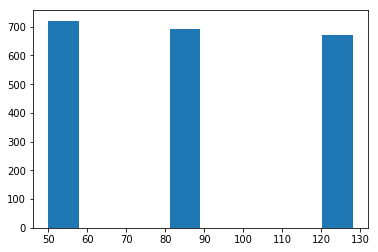

In [12]:
plt.hist(dfnewfilterd['class'])
plt.show()

# Is the dataset balanced?

**Your answer**: (Yes)

Plot a scatter plot where the first dimension is latitude, the second is longitude, and each point is a Pokemon. Further, the color of each point should represent which Pokemon it is. Lastly, the marker at each point should be an `'x'`. Make sure to label each axis.

Hints:

- The `scatter` method from `matplotlib` accepts an argument called `c`.
- The `scatter` method also accepts an argument called `marker`.

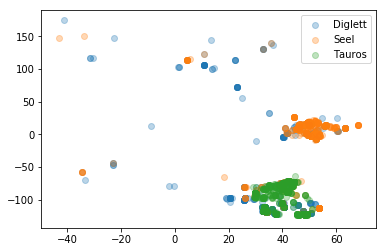

In [13]:

fig, ax = plt.subplots()
tempdf = dfnewfilterd.set_index('class')
for classes in ['Diglett', 'Seel', 'Tauros']:
    ax.scatter(tempdf.loc[name_dict[classes]]['latitude'],tempdf.loc[name_dict[classes]]['longitude'], label=classes, alpha = 0.3)

ax.legend()
plt.show()

Is there any other visualization you think would be useful? If so, insert it here.

How hard do you think the problem is? Which classes can/cannot be easily separated?

**Your answer**: (The problem is not linearly separable with zero loss but both Tauros and Seel are pretty well clusterd as one would expect from those two particular Pokémon's. Diglett on the other hand seem to have a much higher variance appering in relatively the same rate in both the Touros nest as well as the Seel nest. Diglett will thus be the hard one to predict, however the large varience for Digglet and the relative low varience for Seel and Tauros might make it much easier to classify Diglett the one might originaly expect   )

Which accuracy do you expect to achieve?

**Your answer**: (For bot Tauros and Seel I'm confident we will achive a higeh predictive accuracy for simply because of the relatively low varience of these two nests. Digglet on the other hand might be harder but then again the large spread of Diglett relative to the other two might actualy make it much easier to predict then one might expect. For some hard numbers I would estimate us geting around 95% predictive acuracy on Tauros about 80% on Seal and 75% on Diglett. But then again, looking at the requirement for this task it seams that I am way to optemistic in my predictions )

## 3. Preprocessing

Prepare input and output vectors.

In [14]:
input_vec = dfnewfilterd[['latitude', 'longitude']].as_matrix()[1:]
input_vec_scaled = preprocessing.scale(input_vec)

class_vec = dfnewfilterd['class'].as_matrix()[1:]
class_vec[class_vec == name_dict['Diglett']] = 0
class_vec[class_vec == name_dict['Seel']] = 1
class_vec[class_vec == name_dict['Tauros']] = 2

Separate your data into training and test sets. 20% of the data should be in the test set.

In [15]:
#np.random.shuffle(input_vec_scaled)
#np.random.shuffle(class_vec)
index = round(len(class_vec)*0.8)
print(index)
input_vec_train, input_vec_test = [input_vec_scaled[:index,:], input_vec_scaled[index:,:]]

class_vec_train, class_vec_test = [class_vec[:index], class_vec[index:]]
print(np.unique(class_vec_train))

1666
[0 1 2]


No handles with labels found to put in legend.


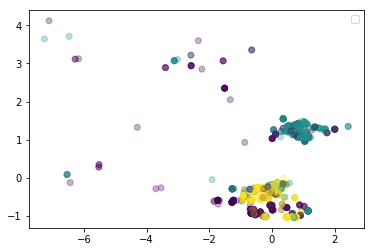

In [16]:
fig, ax = plt.subplots()

ax.scatter(input_vec_train[:,0],input_vec_train[:,1], c=class_vec_train, alpha = 0.3)

ax.legend()
plt.show()

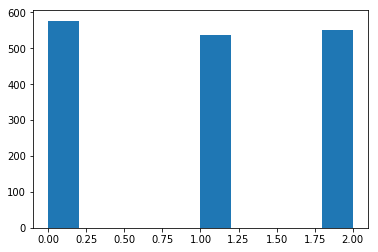

In [17]:
plt.hist(class_vec_train)
plt.show()

## 4. Training

Choose an architecture for your network.

In [18]:
l1 = Dense(40, input_shape = (2,), activation = 'relu')
l2 = Dense(20, activation = 'relu')
l3 = Dense(20, activation = 'relu')
l4 = Dense(3, activation = 'softmax')
model = Sequential([l1, l2, l3, l4])
model.compile(SGD(lr=0.005, momentum=0.0, decay=0.0, nesterov=False),loss='categorical_crossentropy',metrics=['accuracy'])

Train the network. When training, separate 25% of your training data into a validation set.

In [19]:
one_hot_labels = keras.utils.to_categorical(class_vec_train, num_classes=3)

model.fit(x = input_vec_train, y = one_hot_labels,  batch_size=30, epochs=200, verbose=1, validation_split=0.25, shuffle=True)

Train on 1249 samples, validate on 417 samples
Epoch 1/200
1249/1249 [==============================] - 1s 480us/step - loss: 1.1012 - acc: 0.3131 - val_loss: 1.0657 - val_acc: 0.4676
Epoch 2/200
1249/1249 [==============================] - 0s 60us/step - loss: 1.0796 - acc: 0.4091 - val_loss: 1.0473 - val_acc: 0.5492
Epoch 3/200
1249/1249 [==============================] - 0s 61us/step - loss: 1.0583 - acc: 0.4964 - val_loss: 1.0269 - val_acc: 0.6091
Epoch 4/200
1249/1249 [==============================] - 0s 62us/step - loss: 1.0373 - acc: 0.5396 - val_loss: 1.0067 - val_acc: 0.6259
Epoch 5/200
1249/1249 [==============================] - 0s 60us/step - loss: 1.0175 - acc: 0.5837 - val_loss: 0.9864 - val_acc: 0.6547
Epoch 6/200
1249/1249 [==============================] - 0s 62us/step - loss: 0.9993 - acc: 0.6005 - val_loss: 0.9667 - val_acc: 0.6211
Epoch 7/200
1249/1249 [==============================] - 0s 66us/step - loss: 0.9833 - acc: 0.5925 - val_loss: 0.9481 - val_acc: 0.6235


Epoch 120/200
1249/1249 [==============================] - 0s 64us/step - loss: 0.7132 - acc: 0.7062 - val_loss: 0.7100 - val_acc: 0.7194
Epoch 121/200
1249/1249 [==============================] - 0s 63us/step - loss: 0.7127 - acc: 0.7070 - val_loss: 0.7085 - val_acc: 0.7194
Epoch 122/200
1249/1249 [==============================] - 0s 62us/step - loss: 0.7121 - acc: 0.7086 - val_loss: 0.7083 - val_acc: 0.7194
Epoch 123/200
1249/1249 [==============================] - 0s 68us/step - loss: 0.7121 - acc: 0.7062 - val_loss: 0.7102 - val_acc: 0.7170
Epoch 124/200
1249/1249 [==============================] - 0s 67us/step - loss: 0.7124 - acc: 0.7094 - val_loss: 0.7103 - val_acc: 0.7170
Epoch 125/200
1249/1249 [==============================] - 0s 65us/step - loss: 0.7110 - acc: 0.7102 - val_loss: 0.7109 - val_acc: 0.7194
Epoch 126/200
1249/1249 [==============================] - 0s 63us/step - loss: 0.7108 - acc: 0.7094 - val_loss: 0.7106 - val_acc: 0.7194
Epoch 127/200
1249/1249 [=========

For you to pass this assignment, you must obtain an accuracy on the validation set greater than 50%. It may be necessary to search for a good architecture by trying several different ones. If you want a challenge, try getting an accuracy greater than 63%.

## 5. Evaluation

Once you achieved at least 50% accuracy in the validation set, we are done with training. Now we'll evaluate the performance of your classifier on the test set.

Compute the accuracy on the test set.

In [20]:
one_hot_labels_Test = keras.utils.to_categorical(class_vec_test, num_classes=3)
score = model.evaluate(input_vec_test, one_hot_labels_Test, batch_size=10)
print(score)

416/416 [==============================] - 0s 82us/step
[0.7553845145381414, 0.6923076958897022]


Compute the confusion matrix of your predictions on the test set.

In [29]:

predict_vec = np.argmax(model.predict(x = input_vec_test, batch_size=None, verbose=0, steps=None),axis=1)

confusion_matrix(predict_vec,class_vec_test , labels=None, sample_weight=None)
print(predict_vec)

[0 2 1 1 2 1 2 1 1 0 0 1 2 1 2 0 1 2 2 1 1 1 0 1 0 1 2 1 2 1 0 0 2 1 2 0 1
 2 2 0 0 1 2 1 1 1 2 2 2 2 2 1 0 1 2 0 2 0 1 2 0 0 2 2 1 1 2 1 2 2 1 2 1 1
 2 2 1 1 2 2 1 0 0 0 1 0 2 0 1 1 0 0 1 0 1 2 0 0 2 2 0 2 1 2 1 0 0 1 0 1 1
 1 0 2 1 1 2 2 1 2 1 0 1 2 1 2 1 1 1 2 0 1 1 2 1 1 2 1 2 2 0 2 1 2 1 2 1 1
 0 2 0 0 1 1 2 2 1 1 2 1 0 1 0 0 2 1 1 0 1 1 1 0 1 1 1 1 2 0 1 1 1 1 1 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 2 0 1 1 1 2 2 1 1
 2 1 0 2 2 0 1 2 1 1 1 1 1 0 2 1 0 1 2 0 2 1 2 0 0 2 1 1 2 0 2 0 0 1 0 2 0
 1 2 0 2 2 0 1 0 0 2 2 0 2 0 2 2 1 2 2 0 2 0 1 2 0 2 0 0 2 0 0 0 1 0 1 0 0
 0 0 2 0 2 2 0 0 2 0 0 0 2 0 2 2 0 2 2 2 2 0 0 2 0 2 1 0 2 0 1 2 2 2 2 0 0
 1 2 2 0 0 0 2 0 2 0 0 0 0 2 2 2 0 0 2 0 0 2 2 0 2 1 1 0 2 0 2 2 2 2 2 2 2
 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0 2 1 0 2 0 0 2 2 0 0 2 0 2 2 1 2 2 2 2 2 0
 0 0 1 1 0 0 1 0 2]


## 6. Exploration

You have now trained and evaluated a neural network for this particular classification task. Can you provide a brief explanation as to how you could use it to decide where to travel, if you're interested in capturing the aforementioned Pokemons?

**Answer**: (What you would do is to to form the decision boundary for the three classes and then go hunting for the specific pokémon in the region you predict it would be in.)

Is(are) there any other feature(s) from the original dataset (e.g. hour of the day, pressure, wind speed, population density, etc.) which you think would be valuable to add as an input feature to your classifier to improve its performance? 

**Your answer**: (In pokemon go there is a bios for types during different weather. Diglett, Seel and Tauros are all in different weather groups so this would be  feature to try and see if it can contribute to the model. There are also different biomes for each spawn point which influence what pokemon are more likely to spawn there)

To investigate your hypothesis, plot a histogram of the selected feature(s) for each one of the pokemons we're interested in. For example, if you think pressure and population density are valuable for prediction, plot 6 histograms. 3 of them will be the pressure histograms for each class ('Diglett', 'Seel' and 'Tauros'), and the other 3 will be the population density for each class.

C:\Users\sandr\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


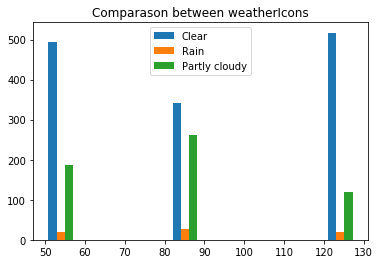

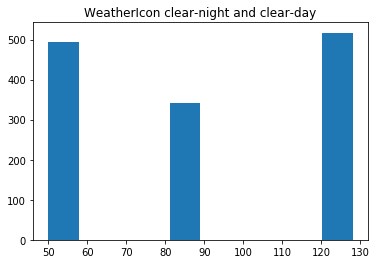

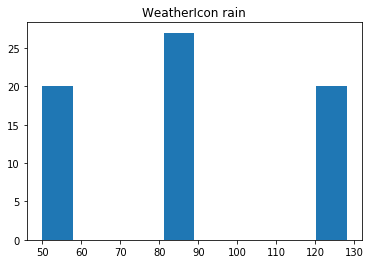

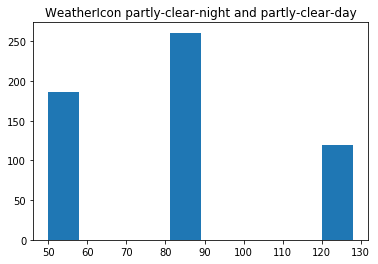

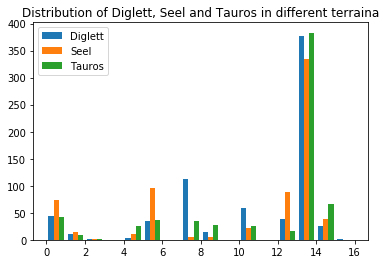

In [89]:
# fog, clear-night, partly-cloudy-night, partly-cloudy-day, cloudy, clear-day, rain, wind

# investigation of weatherIcon
df_inv_wIcon = df[['weatherIcon','class']]
df_inv_wIcon = df_inv_wIcon[df_inv_wIcon['class'].isin([name_dict['Diglett'], name_dict['Seel'], name_dict['Tauros']])]
df_inv_wIcon_Tauros = df_inv_wIcon[df_inv_wIcon['weatherIcon'].isin(['partly-cloudy-night','partly-cloudy-day'])]
df_inv_wIcon_Seel = df_inv_wIcon[df_inv_wIcon['weatherIcon'].isin(['rain'])]
df_inv_wIcon_Diglett = df_inv_wIcon[df_inv_wIcon['weatherIcon'].isin(['clear-night','clear-day'])]

#investigation of terrainType
df_inv_tType = df[['terrainType','class']]
df_inv_ttype = df_inv_tType[df_inv_tType['class'].isin([name_dict['Diglett'],name_dict['Seel'], name_dict['Tauros']])]
df_inv_tType_Diglett = df_inv_tType[df_inv_tType['class'] == name_dict['Diglett']]
df_inv_tType_Seel = df_inv_tType[df_inv_tType['class'] == name_dict['Seel']]
df_inv_tType_Tauros = df_inv_tType[df_inv_tType['class'] == name_dict['Tauros']]

#Plots for weatherIcon investigation
fig_1, ax_weather_1 = plt.subplots()
fig_2, ax_weather_2 = plt.subplots()
fig_3, ax_weather_3 = plt.subplots()
fig_4, ax_weather_4 = plt.subplots()

list_2 = [df_inv_wIcon_Diglett['class'],df_inv_wIcon_Seel['class'],df_inv_wIcon_Tauros['class']]
list_2_label=['Clear','Rain','Partly cloudy']

ax_weather_1.hist(list_2, label = list_2_label)
ax_weather_2.hist(df_inv_wIcon_Diglett['class'], stacked=True)
ax_weather_3.hist(df_inv_wIcon_Seel['class'],stacked=True)
ax_weather_4.hist(df_inv_wIcon_Tauros['class'],stacked=True)

ax_weather_1.set_title('Comparason between weatherIcons')
ax_weather_2.set_title('WeatherIcon clear-night and clear-day')
ax_weather_3.set_title('WeatherIcon rain')
ax_weather_4.set_title('WeatherIcon partly-clear-night and partly-clear-day')

ax_weather_1.legend()

#Plots for terrainType
fig_5, ax_terrain_1 = plt.subplots()

list_1=[df_inv_tType_Diglett['terrainType'], df_inv_tType_Seel['terrainType'], df_inv_tType_Tauros['terrainType']]
ax_terrain_1.hist(list_1,rwidth=0.8,align='mid',bins=16,label=['Diglett','Seel','Tauros'])

ax_terrain_1.set_title('Distribution of Diglett, Seel and Tauros in different terraina')

ax_terrain_1.legend()


plt.show()

What does(do) this(ese) histogram(s) show you? Could it be beneficial to add this(ese) new feature(s) as input? Explain why/why not.

**Your answer**: (In our new feature set we do indeed see some patterns that may be useful for classification. For our weather icon feature we did only look at the three different weather icons that does boost the spawn rate for each of our pokemons type. The low number of catches during rain may just be a sign that not that many people are out catching while it rains. Therefore we will not consider that particular feature statistically significant. However for both clear and partly cloudy weather we also do have a great number of sightings, we also see significant deviations between the three types which might indicate that this feature could be useful for separating the three classes. Our second feature that we looked at was biom of the sighting, here we also see that there is some spots where certain types are found more often than others even though most were found in the same type of biome. Again this might indicate that we can benefit from including this feature in our classification net.)

## 7. (optional)

Assuming you found useful new features in the last part of this assignment, train a new classifier that uses these featues as well. Did the accuracy on the validation set improve? What's the highest accuracy you can achieve?